# Regularization

In this exercise we will take a look at simple but effective methods used to combat overfitting when learning neural networks. We will use a very small subset of the FashionMNIST dataset to artificially induce overfitting, train and evaluate our model. Finally we will look at how to incorporate early stopping and how adding noise to our data makes our model more robust.

In [17]:
from typing import Callable
from functools import partial

import torch
from torch import nn
from torch.optim import Optimizer, SGD

from torchvision.transforms import v2

from solution import *
from utils import *

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
DEVICE

'cpu'

# Training configuration

Throughout this notebook we will use the following training configuration:

In [18]:
TRAIN_SET_SIZE = 200
VAL_SET_SIZE = 1000
EPOCHS = 500
HIDDEN_DIMS = [64, 32]
LR = 0.05
BATCH_SIZE = 32

# Dataset (FashionMNIST)

As mentioned before, we will use the FashionMNIST dataset. This dataset behaves exactly the same as the standard MNIST dataset (grayscale images with height and width of 28 pixels, 10 classes (0-9), train set with 60k samples and test set with 10k samples) with the only difference being the depicted images. While MNIST shows handwritten digits, FashionMNIST shows 10 different types of clothing. Example images are shown after execution of the following cell.

Shape of images is torch.Size([32, 1, 28, 28])


/Users/I551991/Projects/AI Playground/.venv/lib/python3.13/site-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


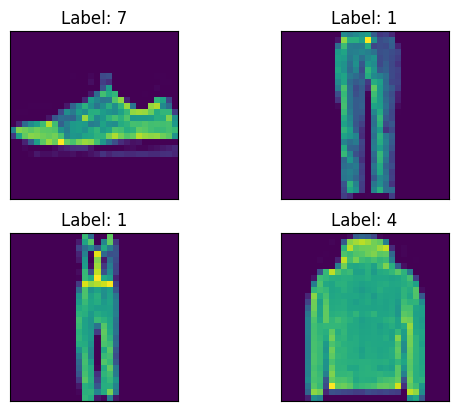

In [19]:
train_set, val_set, test_set = get_fashion_mnist_subset(TRAIN_SET_SIZE, VAL_SET_SIZE, transforms=v2.ToTensor())

train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_set, batch_size=BATCH_SIZE)
test_loader = DataLoader(test_set, batch_size=BATCH_SIZE)

visualize_first_4(train_loader)

# Create model

First, we need a function to create a model that is able to classify FashionMNIST data. The model takes in inputs of the shape (batch_size x 1 x 28 x 28) and outputs a 10-dimensional vector. It should first flatten the input images, then apply a given number of linear layers to it, and finally map to a 10-dimensional vector which will be used to predict which type of clothing it is.

In [20]:
def create_model(hidden_dims: list[int]):  
    """Create a model that works for classifying the FahsionMNIST dataset."""
    model = nn.Sequential(
        nn.Flatten(),
        nn.Linear(28*28, hidden_dims[0]),
        nn.ReLU(),
        *[nn.Sequential(nn.Linear(in_feats, out_feats), nn.ReLU())
            for in_feats, out_feats in zip(hidden_dims[:-1], hidden_dims[1:])],
        nn.Linear(hidden_dims[-1], 10)
    )
    model.to(DEVICE)
    return model

# Train, evaluate and save models

In [21]:
def train_one_epoch(model, dataloader, optimizer):
    losses = []
    for batch, labels in dataloader:
        batch = batch.to(DEVICE)
        labels = labels.to(DEVICE)

        optimizer.zero_grad()

        preds = model(batch)
        loss = cross_entropy(preds, labels)
        loss.backward()
        optimizer.step()

        losses.append(loss.item())

    avg_loss = sum(losses) / len(losses)
    return avg_loss

Function that iterates through a dataloader, and outputs the average loss and accuracy. Make sure that no gradient computation is triggered, e.g. use [torch.no_grad()](https://pytorch.org/docs/stable/generated/torch.no_grad.html). Furthermore, make sure that your model in evaluation mode and to switch back afterwards. This will be important for the last task where we are adding Dropout layers to our neural network. For more information see [this](https://stackoverflow.com/questions/60018578/what-does-model-eval-do-in-pytorch) StackOverflow question.


In [22]:
def validate(model: nn.Module, dataloader: DataLoader) -> tuple[float, float]:
    losses = []
    accuracies = []

    model.eval()  # TODO: explain in markdown

    with torch.no_grad():  # TODO: explain in markdown
        for batch, labels in dataloader:
            batch = batch.to(DEVICE)
            labels = labels.to(DEVICE)

            preds = model(batch)

            loss = cross_entropy(preds, labels)
            losses.append(loss.item())

            accuracy = torch.sum(torch.argmax(preds, dim=-1) == labels)
            accuracies.append(accuracy.item() / len(labels))

    model.train()  # TODO: explain in markdown

    avg_loss = sum(losses) / len(losses)
    avg_accuracy = sum(accuracies) / len(accuracies)
    return avg_loss, avg_accuracy

Here we define our complete training function. It simply iterates for `n_epochs` epochs through the training dataset, evaluates after each epoch on the validation dataset, and finally returns an array with the train and validation losses for each epoch. An important feature of this training function is that it can take a function as an argument (that's the `callback` argument) which gets the model, the current epoch, the array of train losses up until this point, the array of validation losses until this point and the last validation accuracy. The follwing tasks will partly consist of writing functions that we will pass into the training function.

In [23]:
def train(
        model: nn.Module,
        train_loader: DataLoader,
        val_loader: DataLoader,
        optimizer: Optimizer,
        n_epochs: int,
        callback: Callable[[nn.Module, int, list[float], list[float], float], None]
    ) -> tuple[list[float], list[float]]:
    train_losses = []
    val_losses = []
    for epoch in range(n_epochs):
        train_loss = train_one_epoch(model, train_loader, optimizer)
        val_loss, val_acc = validate(model, val_loader)

        train_losses.append(train_loss)
        val_losses.append(val_loss)

        callback(model, epoch, train_losses, val_losses, val_acc)

    return train_losses, val_losses


Function that we can pass into the training function above that prints the current stats every `n` epochs. This function shouldn't return anything.

In [24]:
def print_loss_every_n_epochs(
        model: nn.Module,
        epoch: int,
        train_losses: list[float],
        val_losses: list[float],
        val_acc,
        n: int) -> None:
    if epoch % n == 0:
        print(f"[EPOCH {epoch}] Train loss: {train_losses[-1]:.4f}, Validation loss: {val_losses[-1]:.4f}, Validation accuracy: {val_acc:.4f}")

Next we will train a model. We will use the above defined hyperparameters, and a simple SGD optimizer. Furthermore we will print the training stats every epoch.

[EPOCH 0] Train loss: 2.2849, Validation loss: 2.2765, Validation accuracy: 0.2520
[EPOCH 1] Train loss: 2.2539, Validation loss: 2.2527, Validation accuracy: 0.3047
[EPOCH 2] Train loss: 2.2164, Validation loss: 2.2245, Validation accuracy: 0.3252
[EPOCH 3] Train loss: 2.1686, Validation loss: 2.1864, Validation accuracy: 0.3857
[EPOCH 4] Train loss: 2.1017, Validation loss: 2.1303, Validation accuracy: 0.3730
[EPOCH 5] Train loss: 2.0263, Validation loss: 2.0581, Validation accuracy: 0.3994
[EPOCH 6] Train loss: 1.9345, Validation loss: 1.9830, Validation accuracy: 0.3740
[EPOCH 7] Train loss: 1.7942, Validation loss: 1.8964, Validation accuracy: 0.3896
[EPOCH 8] Train loss: 1.6584, Validation loss: 1.8247, Validation accuracy: 0.3750
[EPOCH 9] Train loss: 1.5575, Validation loss: 1.6925, Validation accuracy: 0.3936


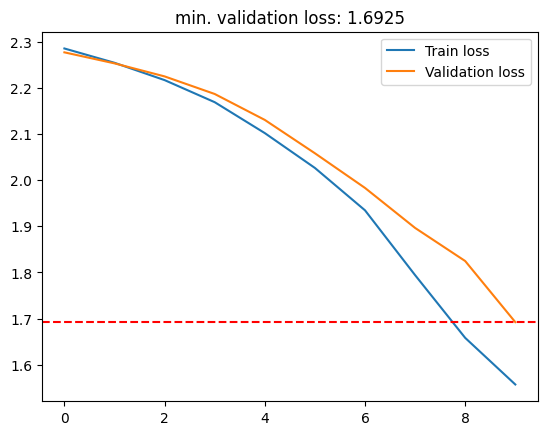

In [25]:
model = create_model(HIDDEN_DIMS)
optimizer = SGD(model.parameters(), lr=LR)

train_losses , val_losses = train(model,
                                   train_loader,
                                   val_loader,
                                   optimizer,
                                   n_epochs=10,
                                   callback=partial(print_loss_every_n_epochs, n=1))

plot_train_and_val_loss(train_losses, val_losses, title=f"min. validation loss: {min(val_losses):.4f}")

# Early stopping

Early stopping is the most simple thing to prevent your final model to overfit: you simply track train and test errors and use a model checkpoint before your model started to overfit.

Implementing early stopping is pretty straight forward. Simply save your model each time you've reached a new best validation loss, and otherwise don't. To reduce clutter in your filesystem you can simply override the saved model each time. Saving and loading PyTorch models is described in [this guide](https://pytorch.org/tutorials/beginner/saving_loading_models.html). The function to load models is given.

In [26]:
def save_model_if_improved(model, epoch, train_losses, val_losses, val_acc, filename):
    if val_losses[-1] == min(val_losses):
        print(f"Found new best model at epoch {epoch} with a validation loss of {val_losses[-1]:.4f}")
        torch.save(model.state_dict(), filename)

def load_model(model, model_file_path: str) -> nn.Module:
    model.load_state_dict(torch.load(model_file_path, weights_only=True))
    return model

This time we will train our model for more epochs, to show how it overfits. Your implemented function should stop saving the model once the model starts to overfit.

Found new best model at epoch 0 with a validation loss of 2.2900
Found new best model at epoch 1 with a validation loss of 2.2651
Found new best model at epoch 2 with a validation loss of 2.2371
Found new best model at epoch 3 with a validation loss of 2.1928
Found new best model at epoch 4 with a validation loss of 2.1499
Found new best model at epoch 5 with a validation loss of 2.0880
Found new best model at epoch 6 with a validation loss of 2.0244
Found new best model at epoch 7 with a validation loss of 1.9498
Found new best model at epoch 8 with a validation loss of 1.8426
Found new best model at epoch 9 with a validation loss of 1.7825
Found new best model at epoch 10 with a validation loss of 1.6432
Found new best model at epoch 11 with a validation loss of 1.5856
Found new best model at epoch 12 with a validation loss of 1.5362
Found new best model at epoch 13 with a validation loss of 1.5037
Found new best model at epoch 14 with a validation loss of 1.3628
Found new best model

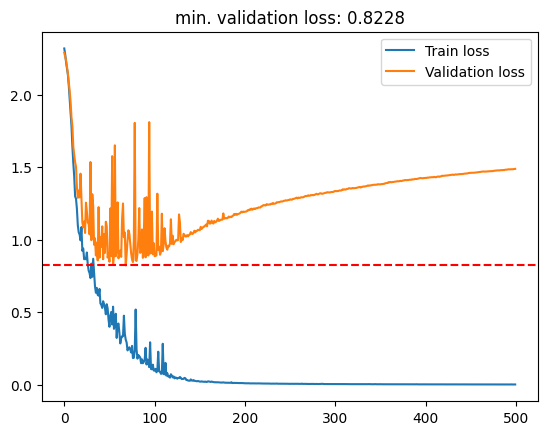

In [27]:
model = create_model(HIDDEN_DIMS)
optimizer = SGD(model.parameters(), lr=LR)
train_losses, val_losses = train(model,
                                train_loader,
                                val_loader,
                                optimizer,
                                n_epochs=EPOCHS,
                                callback=partial(save_model_if_improved, filename="early_stopping.pth"))

plot_train_and_val_loss(train_losses, val_losses, title=f"min. validation loss: {min(val_losses):.4f}")

We now evaluate our model on the test set, to get a better estimate of the generalization error. As you can see we've named the model

In [28]:
pretrained_model = create_model(HIDDEN_DIMS)
load_model(pretrained_model, model_file_path="early_stopping.pth")
test_loss, test_accuracy = validate(pretrained_model, test_loader)

print(f"Early stopping model achieved test loss of {test_loss:.4f} and accuarcy {test_accuracy:.4f}")

Early stopping model achieved test loss of 0.8592 and accuarcy 0.7066


# Dropout

Dropout is a technique where neurons are randoml set to zero, which introduces noise into the network, and helps to generalize better. Details are described in [this blogpost](https://towardsdatascience.com/dropout-in-neural-networks-47a162d621d9).

Function similar to the one above where we build a standard feed forward network. But now, after each activation layer, add a [nn.Dropout()](https://pytorch.org/docs/stable/generated/torch.nn.Dropout.html) layer with the dropout probability specified in the parameter `p`.

In [29]:
def create_model_with_dropout(hidden_dims: list[int], p: float):
    model = nn.Sequential(
        nn.Flatten(),
        nn.Linear(28*28, hidden_dims[0]),
        nn.ReLU(),
        nn.Dropout(p),
        *[nn.Sequential(nn.Linear(in_feats, out_feats), nn.ReLU(), nn.Dropout(p))
            for in_feats, out_feats in zip(hidden_dims[:-1], hidden_dims[1:])],
        nn.Linear(hidden_dims[-1], 10)
    )
    model.to(DEVICE)

    return model

Next we will train a neural network with the exact same parameters as above, only that we now have added dropout layers.

Found new best model at epoch 0 with a validation loss of 2.2895
Found new best model at epoch 2 with a validation loss of 2.2885
Found new best model at epoch 3 with a validation loss of 2.2792
Found new best model at epoch 4 with a validation loss of 2.2711
Found new best model at epoch 5 with a validation loss of 2.2656
Found new best model at epoch 6 with a validation loss of 2.2637
Found new best model at epoch 7 with a validation loss of 2.2546
Found new best model at epoch 8 with a validation loss of 2.2471
Found new best model at epoch 11 with a validation loss of 2.2325
Found new best model at epoch 12 with a validation loss of 2.2063
Found new best model at epoch 17 with a validation loss of 2.1907
Found new best model at epoch 18 with a validation loss of 2.1903
Found new best model at epoch 19 with a validation loss of 2.1813
Found new best model at epoch 20 with a validation loss of 2.1677
Found new best model at epoch 21 with a validation loss of 2.1543
Found new best mod

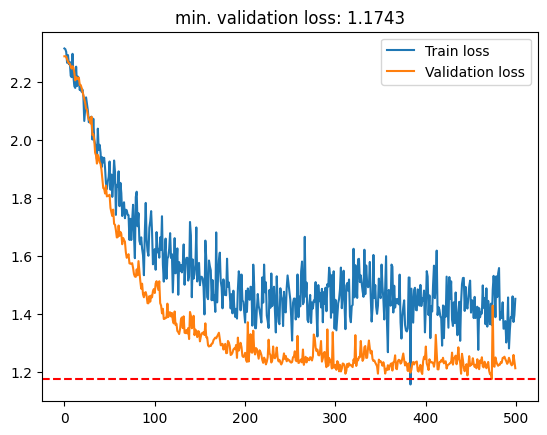

In [30]:
DROPOUT = 0.8

model = create_model_with_dropout(HIDDEN_DIMS, p=DROPOUT)
optimizer = SGD(model.parameters(), lr=LR)

train_losses, val_losses = train(model,
                                train_loader,
                                val_loader,
                                optimizer,
                                n_epochs=EPOCHS,
                                callback=partial(save_model_if_improved, filename="dropout.pth"))

plot_train_and_val_loss(train_losses, val_losses, title=f"min. validation loss: {min(val_losses):.4f}")

In [31]:
pretrained_model = create_model_with_dropout(HIDDEN_DIMS, DROPOUT)
load_model(pretrained_model, "dropout.pth")
test_loss, test_accuracy = validate(pretrained_model, test_loader)

print(f"Dropout model achieved test loss of {test_loss:.4f} and accuracy of {test_accuracy:.4f}")

Dropout model achieved test loss of 1.1612 and accuracy of 0.5068
